In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc
from code.generate_data import SinteticData
from code.representation import *
from code.utils import *
from code.learning_models import *
from code.baseline import RaykarMC,LabelInference
from code.MixtureofGroups import GroupMixtureOpt

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

matplotlib.rc('axes', titlesize=25)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=25)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

to_check = [100,2000,5000,10000,15000,25000,40000]
to_check

Using TensorFlow backend.


[100, 2000, 5000, 10000, 15000, 25000, 40000]

100
2000
5000
10000
15000
25000
40000
CIFAR example 50k exaples, 10 classes


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


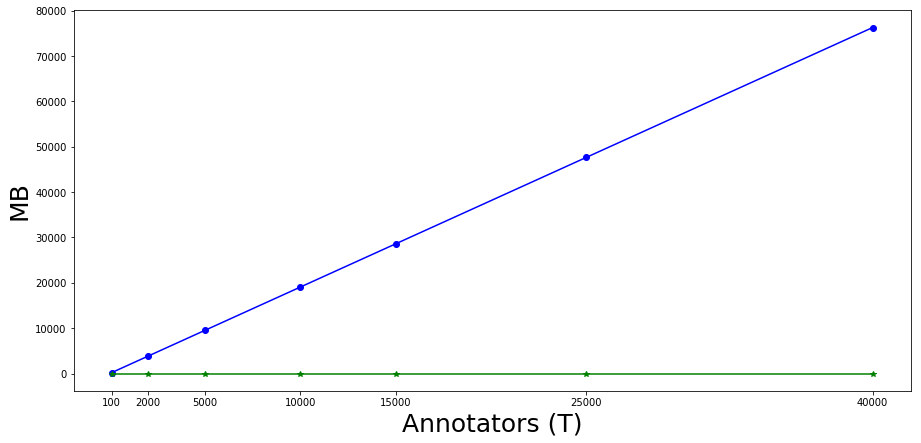

In [4]:
memory_cons = []
N = 50000
K = 10
for t in to_check:
    print(t)
    a = np.zeros((N,t,K),dtype='float32') #int8
    memory_cons.append(a.nbytes/(1024*1024)) #MB

plt.figure(figsize=(15,7))
ours_consume = np.zeros((N,K),dtype='float32').nbytes/(1024*1024)
print("CIFAR example 50k exaples, 10 classes")
plt.plot(to_check,memory_cons,'bo-',label="Repeat consume")
#plt.hlines(ours_consume,0,25000, 'g' , label="Global consume")
plt.plot(to_check,np.tile(ours_consume,len(to_check)),'g*-',label="Global consume")
#plt.hlines(16000,0,to_check[-1], color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators (T)")
#plt.legend()
plt.show()

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
N = Z_train.shape[0]
GenerateData = SinteticData(state=None)

#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix='./synthetic/simple/matrix_datasim_normal.csv',file_groups ='./synthetic/simple/groups_datasim_normal.csv')

#GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

In [4]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [5]:
to_check = [100,2000,5000,10000,15000,25000,40000]
T_data = 10 

annot_acc = []
raykar_exec = []
raykar_init = []
ourglobal_exec = []
ourglobal_init = []
mv_exec = []
ds_exec = []
for Tmax in to_check:
    aux_annot_acc = []
    aux_raykar_exec = []
    aux_raykar_init = []
    aux_ourglobal_exec = []
    aux_ourglobal_init = []
    aux_mv_exec = []
    aux_ds_exec = []
    for _ in range(10):

        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)

        #annot_acc.append(np.mean(GenerateData.yo_label == Z_train))

        #get representation needed for Raykar
        y_obs_categorical = set_representation(y_obs,'onehot') 

        raykarMC = RaykarMC(X_train.shape[1:],y_obs_categorical.shape[-1],Tmax,epochs=1)
        raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i = raykarMC.multiples_run(1,X_train,y_obs_categorical,max_iter=2)

        aux_raykar_exec.append(raykarMC.current_exectime)
        aux_raykar_init.append(raykarMC.init_exectime)

        del raykarMC
        gc.collect()
        keras.backend.clear_session()

        r_obs = set_representation(y_obs,"repeat")
        gMixture_Global = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=1,pre_init=0) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Global.lambda_random = True #with lambda random --necessary
        logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,max_iter=2,cluster=True)

        aux_ourglobal_exec.append(gMixture_Global.current_exectime)
        aux_ourglobal_init.append(gMixture_Global.init_exectime)
    
        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
        
        mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
        time_callback = TimeHistory()
        model_mvsoft = MLP_Keras(X_train.shape[1:],mv_soft.shape[1],16,1,BN=False,drop=0.2)
        model_mvsoft.compile(loss='categorical_crossentropy',optimizer='adam')
        model_mvsoft.fit(X_train, mv_soft, epochs=2,batch_size=64,verbose=1,callbacks=[time_callback])
        times = time_callback.times
        aux_mv_exec.append(times[-1])
        
        #AND DS???????
        label_I = LabelInference(y_obs,1e-10, type_inf = 'ds', max_iter=3)
        ds_labels,ds_conf = label_I.DS_labels()
        aux_ds_exec.append(label_I.DS_current_exectime)
        
    raykar_exec.append(np.mean(aux_raykar_exec))
    raykar_init.append(np.mean(aux_raykar_init))
    ourglobal_exec.append(np.mean(aux_ourglobal_exec))
    ourglobal_init.append(np.mean(aux_ourglobal_init))
    mv_exec.append(np.mean(aux_mv_exec))
    ds_exec.append(np.mean(aux_ds_exec))
    
raykar_exec = np.asarray(raykar_exec)
raykar_init = np.asarray(raykar_init)
ourglobal_exec = np.asarray(ourglobal_exec)
ourglobal_init = np.asarray(ourglobal_init)
mv_exec = np.asarray(mv_exec)
ds_exec = np.asarray(ds_exec)
print("Done")

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 0.74 sec)	logL: -18577.355	
Iter 2/2 
M step: done,  E step: done //  (in 0.11 sec)	logL: -16798.623	Tol1: 0.09575	Tol2: 0.27453	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003415 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6509898  0.61469805 0.29725298 0.6307546  0.4925987 ]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.65 sec)	logL: -24047.180	
Iter 2/2
M step: done,  E step: done //  (in 0.15 sec)	logL: -22984.371	Tol1: 0.04420	Tol2: 0.41593	Tol3: 0.03393	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 106us/step - loss: 1.0903
Epoch 2/2
2457/2457 [==============================] - 0s 24us/step - loss: 0.995

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75 0.42 0.75 0.78 0.33]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.62 sec)	logL: -24742.537	
Iter 2/2
M step: done,  E step: done //  (in 0.14 sec)	logL: -23845.114	Tol1: 0.03627	Tol2: 0.39997	Tol3: 0.03549	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 122us/step - loss: 1.0549
Epoch 2/2
2457/2457 [==============================] - 0s 32us/step - loss: 0.9702
Representation for DS in 0.503067 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -18586.915101171373
2 	 -17358.05070889201 	0.3670	0.275009	0.066114
3 	 -17064.167087763446 	0.0967	0.210623	0.016931
4 	 -16985.17184973084 	0.0366	0.153748	0.004629
Class marginals
[0.35 0.33 0.32]
Estimation for DS in 1.288141 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: d

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 0.94 sec)	logL: -19515.281	
Iter 2/2 
M step: done,  E step: done //  (in 0.13 sec)	logL: -17775.055	Tol1: 0.08917	Tol2: 0.13579	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002246 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08 0.5  0.71 0.08 0.18]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.64 sec)	logL: -25472.116	
Iter 2/2
M step: done,  E step: done //  (in 0.14 sec)	logL: -23777.145	Tol1: 0.06654	Tol2: 0.50542	Tol3: 0.11743	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 116us/step - loss: 1.0275
Epoch 2/2
2457/2457 [==============================] - 0s 24us/step - loss: 0.9694
Representation for DS in 8.

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15 0.78 0.5  0.56 0.06]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.61 sec)	logL: -25869.871	
Iter 2/2
M step: done,  E step: done //  (in 0.15 sec)	logL: -24526.035	Tol1: 0.05195	Tol2: 0.49979	Tol3: 0.09115	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 93us/step - loss: 1.1539
Epoch 2/2
2457/2457 [==============================] - 0s 26us/step - loss: 1.0498
Representation for DS in 19.893869 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -12253.37127394471
2 	 -9576.719161235666 	0.3600	0.268843	0.218442
3 	 -8991.400696469982 	0.0279	6650.053711	0.061119
4 	 -8820.501793630952 	0.0159	43972.246094	0.019007
Class marginals
[0.38 0.3  0.32]
Estimation for DS in 16.805225 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (5000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M 

Epoch 1/2
2457/2457 [==============================] - 0s 112us/step - loss: 1.0447
Epoch 2/2
2457/2457 [==============================] - 0s 26us/step - loss: 0.9827
Representation for DS in 37.874198 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -9056.637247184959
2 	 -6852.355610400533 	0.3427	0.155948	0.243389
3 	 -6276.585319383241 	0.0377	13047.648438	0.084025
4 	 -6057.14038623111 	0.0193	104861.484375	0.034962
Class marginals
[0.38 0.3  0.33]
Estimation for DS in 29.899256 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.13 sec)	logL: -20463.045	
Iter 2/2 
M step: done,  E step: done //  (in 0.28 sec)	logL: -19355.555	Tol1: 0.05412	Tol2: 0.05223	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002598 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.63 0.5

4 	 -6187.920942304338 	0.0168	106332.625000	0.032464
Class marginals
[0.39 0.29 0.32]
Estimation for DS in 30.394382 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.17 sec)	logL: -20381.922	
Iter 2/2 
M step: done,  E step: done //  (in 0.28 sec)	logL: -19264.346	Tol1: 0.05483	Tol2: 0.05297	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002279 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55 0.34 0.86 0.36 0.7 ]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.62 sec)	logL: -24701.445	
Iter 2/2
M step: done,  E step: done //  (in 0.14 sec)	logL: -23353.749	Tol1: 0.05456	Tol2: 0.50017	Tol3: 0.11016	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 91us/step - l

M step: done,  E step: done //  (in 0.71 sec)	logL: -24264.610	
Iter 2/2
M step: done,  E step: done //  (in 0.14 sec)	logL: -22910.600	Tol1: 0.05580	Tol2: 0.37506	Tol3: 0.07572	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 100us/step - loss: 1.1962
Epoch 2/2
2457/2457 [==============================] - 0s 30us/step - loss: 1.0697
Representation for DS in 64.737010 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -5376.594742318542
2 	 -4186.3440268855275 	0.2344	0.079245	0.221376
3 	 -3741.5211898431426 	0.0817	716.299194	0.106256
4 	 -3568.522195947465 	0.0180	66994.054688	0.046238
Class marginals
[0.38 0.28 0.34]
Estimation for DS in 50.491997 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (25000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.36 sec)	logL: -20652.029	
Iter 2/2 
M step: done,  E step: done //  (in 0.40 sec)	logL: -19619.848	Tol1: 0.04998	Tol2: 0.04180	
Finishe

Representation for DS in 63.850886 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -5463.448262293424
2 	 -4229.335621078477 	0.2372	0.078102	0.225885
3 	 -3787.8707836873527 	0.0817	2467.766602	0.104382
4 	 -3610.1841101131804 	0.0192	65895.039062	0.046909
Class marginals
[0.38 0.29 0.34]
Estimation for DS in 50.300653 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (25000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.47 sec)	logL: -21427.479	
Iter 2/2 
M step: done,  E step: done //  (in 0.47 sec)	logL: -20604.553	Tol1: 0.03841	Tol2: 0.03506	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003220 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85 0.32 0.12 0.35 0.53]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.65 sec)	logL: -24373

Betas shape:  (40000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.56 sec)	logL: -20885.836	
Iter 2/2 
M step: done,  E step: done //  (in 0.44 sec)	logL: -20175.590	Tol1: 0.03401	Tol2: 0.03105	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002582 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54 0.41 0.19 0.77 0.97]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.67 sec)	logL: -24991.311	
Iter 2/2
M step: done,  E step: done //  (in 0.16 sec)	logL: -23748.746	Tol1: 0.04972	Tol2: 0.40795	Tol3: 0.11115	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 94us/step - loss: 1.0643
Epoch 2/2
2457/2457 [==============================] - 0s 29us/step - loss: 0.9711
Representation for DS in 76.033422 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94 0.1  0.13 0.75 0.84]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 0.69 sec)	logL: -24568.600	
Iter 2/2
M step: done,  E step: done //  (in 0.15 sec)	logL: -23589.206	Tol1: 0.03986	Tol2: 0.40759	Tol3: 0.08745	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 106us/step - loss: 1.0564
Epoch 2/2
2457/2457 [==============================] - 0s 27us/step - loss: 0.9884
Representation for DS in 75.831283 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -3928.557034210948
2 	 -3169.432851441476 	0.1242	0.082215	0.193232
3 	 -2839.7929488048 	0.0972	121.349556	0.104006
4 	 -2691.84500168703 	0.0356	26684.193359	0.052098
Class marginals
[0.38 0.26 0.36]
Estimation for DS in 57.956345 sec
Done


In [7]:
import pandas as pd
df = pd.DataFrame({"Raykar exec": raykar_exec, "Raykar init": raykar_init, "Our exec": ourglobal_exec,
                  "Our init": ourglobal_init, "MV exec": mv_exec, "DS exec": ds_exec})
df.to_csv("time_comparison.csv",index=False)
df.head()

,DS exec,MV exec,Our exec,Our init,Raykar exec,Raykar init
0,0.149213,0.068083,0.144551,0.004793,0.099068,0.005901
1,1.079853,0.064119,0.155140,0.004566,0.129765,0.105036
2,2.325447,0.066128,0.145056,0.004490,0.209314,0.261032
3,4.215830,0.067410,0.147432,0.004879,0.294403,0.481122
4,5.521846,0.066169,0.142852,0.004922,0.370990,0.653070


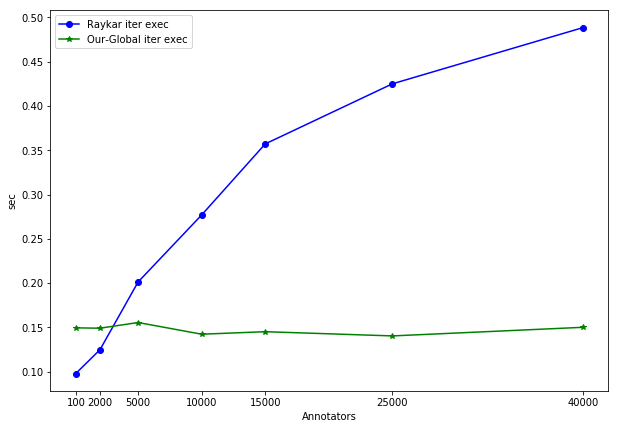

In [12]:
plt.figure(figsize=(10,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec")
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()


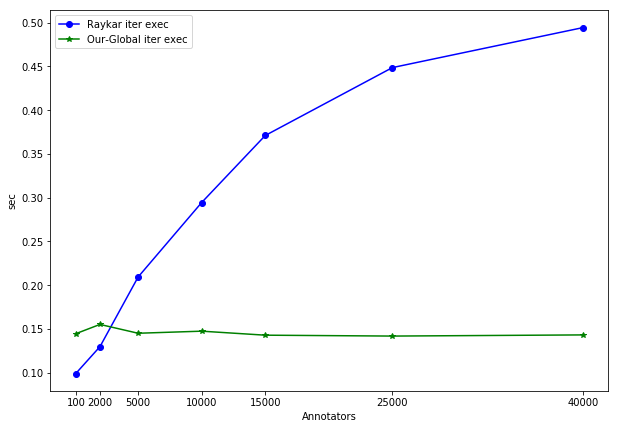

In [9]:
plt.figure(figsize=(10,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec")
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

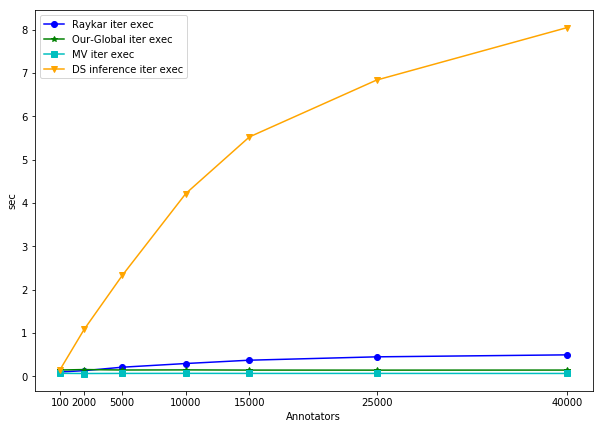

In [8]:

plt.figure(figsize=(10,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec")
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec")
plt.plot(to_check,mv_exec,'cs-',label="MV iter exec")
plt.plot(to_check,ds_exec,'v-',label="DS inference iter exec", color='orange')
#plt.plot(to_check,ds_exec+mv_exec,'p-',label="DS utility iter exec", color='orange')

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

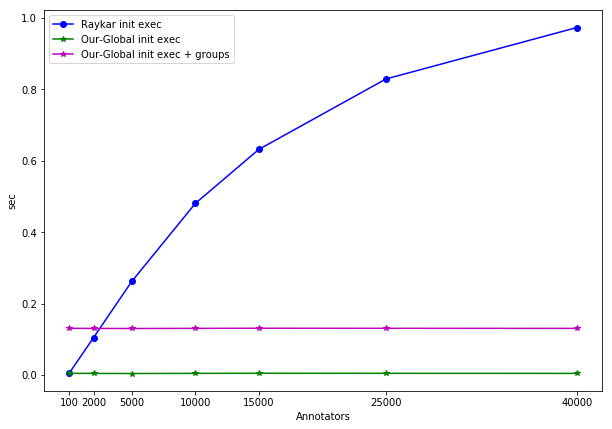

In [22]:
plt.figure(figsize=(10,7))
plt.plot(to_check,raykar_init,'bo-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init,'g*-',label="Our-Global init exec")
plt.plot(to_check,ourglobal_init+0.0021*60,'m*-',label="Our-Global init exec + groups") #datacenter time
#plt.plot(to_check,ourglobal_init+0.0041*60,'m*-',label="Our-Global init exec + groups")# pc-casa time
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

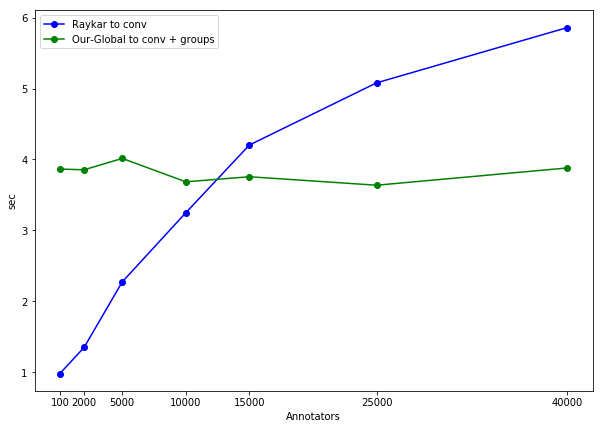

In [23]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 10
Our_iter = 25

plt.figure(figsize=(10,7))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'bo-',label="Raykar to conv")
#plt.plot(to_check,ourglobal_init+ourglobal_exec*Our_iter,'o-',label="Our-Global to conv")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'go-',label="Our-Global to conv + groups") #datacenter
#plt.plot(to_check,ourglobal_init+0.0041*60+ourglobal_exec*Our_iter,'g*-',label="Our-Global to conv + groups")

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

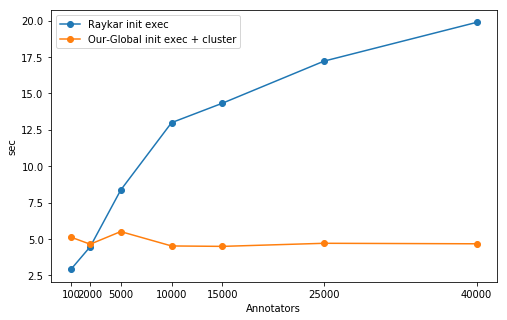

In [7]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 40
Our_iter = 40

plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'o-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec + groups")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

### Future comparison
---

Simple Data


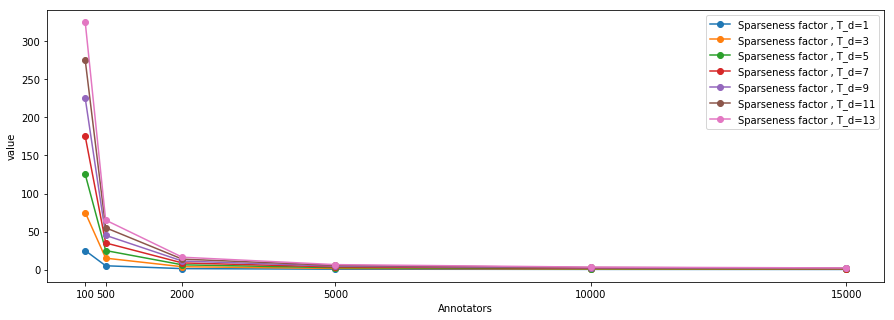

CIFAR Data


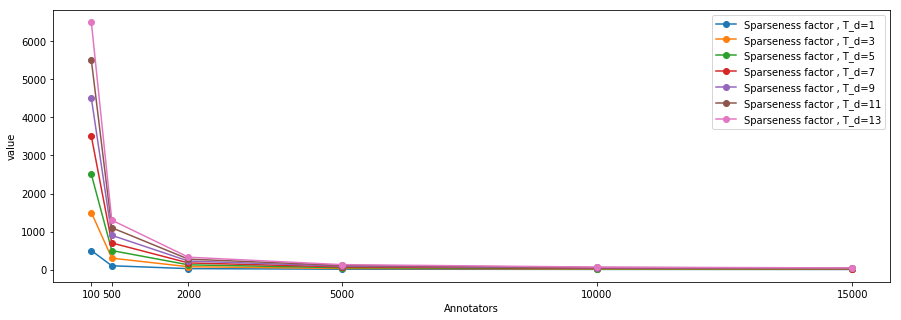

In [22]:
to_check = [100,500,2000,5000,10000,15000]
print("Simple Data")
N = 2500

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

print("CIFAR Data")
N = 50000

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

Simple Data


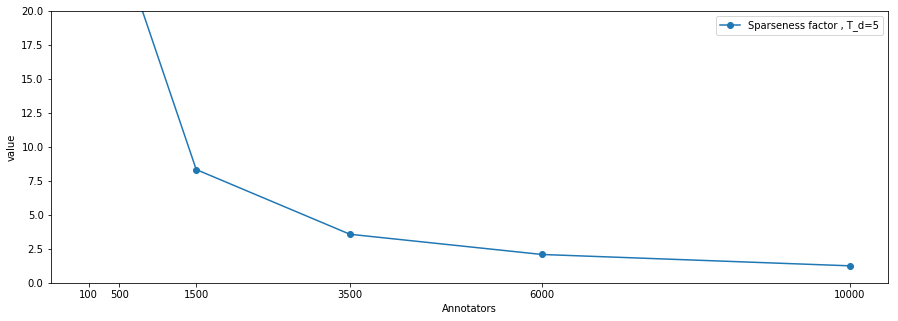

CIFAR Data


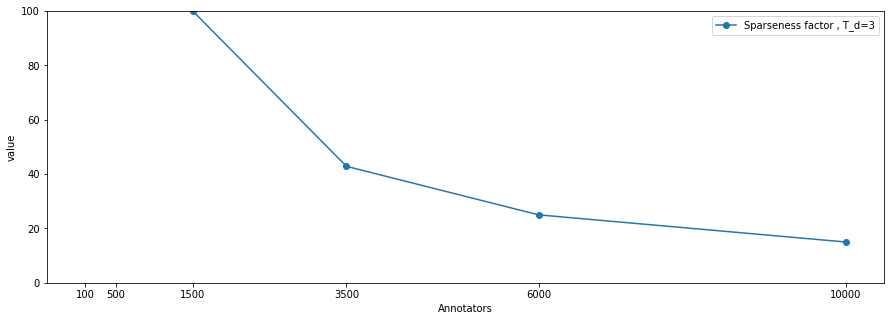

In [54]:
to_check = [100,500,1500,3500,6000,10000]
print("Simple Data")
N = 2500

plt.figure(figsize=(15,5))
T_data = 5 #5 para llegar solo a 10k o 10 para llegar a 15k
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,20)

plt.show()

print("CIFAR Data")
N = 50000
T_data = 3 #para poder ver sparness factor mas bajos..
plt.figure(figsize=(15,5))
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,100)
plt.show()

In [46]:
np.linspace(100,10000,6)

array([  100.,  2080.,  4060.,  6040.,  8020., 10000.])

In [4]:
to_check = [25,100,500,2000,5000,10000]


T_d= 5


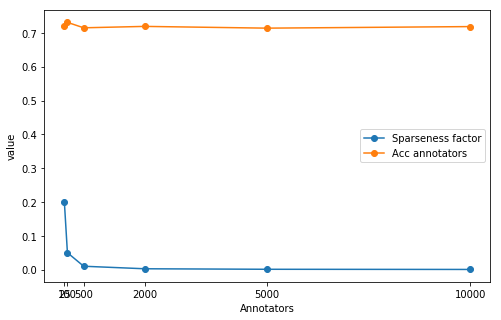

In [43]:
N = Z_train.shape[0]
#fixing T_d
T_data = 5
print("T_d=",T_data)
D_t = np.asarray([N*T_data/T for T in to_check])

annot_acc = []
for Tmax in to_check:
    aux = []
    for _ in range(10):
        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)
        aux.append(np.mean(GenerateData.yo_label == Z_train))
    annot_acc.append(np.mean(aux))
    
plt.figure(figsize=(8,5))
plt.plot(to_check,D_t/N,'o-',label="Sparseness factor")
plt.plot(to_check,annot_acc,'o-',label="Acc annotators")
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()